# Notebook to Examine Length of "Zero SWE season" 

# Step 0 Set up Notebook

In [1]:
import pandas as pd
import boto3
import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
from snowML.datapipe import data_utils as du 


# Step 1 - Define Functions to Gather Data

In [2]:
def get_UA_data(huc_id): 
    f = f"mean_swe_in_{huc_id}.csv"
    b = "snowml-gold"
    df = du.s3_to_df(f, b)
    df.set_index('day', inplace=True)
    df.index = pd.to_datetime(df.index)
    df["mean_swe"] = df["mean_swe"]/1000
    return df

# Step 2 Define Function to Calculate Zero SWE Days Per Month

In [3]:

def calc_zero_swe_stats(df):
    # Ensure index is datetime
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    
    # Create year and month columns
    df['year'] = df.index.year
    df['month'] = df.index.month
    
    # Flag days where mean_swe is zero
    df['is_zero'] = df['mean_swe'] == 0
    
    # Group by year and month
    summary = df.groupby(['year', 'month']).agg(
        zero_days=('is_zero', 'sum'),
        total_days=('is_zero', 'count')
    )
    
    # Calculate percentage
    summary['percent_zero'] = (summary['zero_days'] / summary['total_days']) * 100
    
    return summary.reset_index()

In [4]:
def filter_summer_months(summary, begin = 7, end = 9):
    return summary[summary['month'].between(begin, end)]

In [5]:
def filter_by_percent_zero(summer_summary, threshold=80):
    # Filter based on threshold
    filtered_df = summer_summary[summer_summary['percent_zero'] < threshold]

    # Group by month to calculate summary stats
    month_stats = (
        summer_summary.groupby('month')
        .agg(total_years=('year', 'nunique'))
        .join(
            filtered_df.groupby('month')
            .agg(years_below_threshold=('year', 'nunique')),
            how='left'
        )
        .fillna(0)
    )

    # Compute percent of years below threshold
    month_stats['percent_years_below_threshold'] = (
        month_stats['years_below_threshold'] / month_stats['total_years'] * 100
    )

    # Add total row
    total_row = pd.DataFrame({
        'total_years': [month_stats['total_years'].sum()],
        'years_below_threshold': [month_stats['years_below_threshold'].sum()],
    })
    total_row['percent_years_below_threshold'] = (
        total_row['years_below_threshold'] / total_row['total_years'] * 100
    )
    total_row.index = ['Total']

    # Combine with original month_stats
    month_stats = pd.concat([month_stats, total_row])

    return filtered_df, month_stats.reset_index()



In [6]:
def total_below_threshold(huc_id, begin = 7, end = 9, threshold=80): 
    df = get_UA_data(huc_id)
    summary = calc_zero_swe_stats(df)
    summer_months = filter_summer_months(summary, begin = begin, end = end)
    _, month_stats = filter_by_percent_zero(summer_months, threshold = threshold)
    return month_stats

In [7]:
def plot_percent_below_thresh_hist(df_results, bins=10):
    plt.figure(figsize=(8, 5))
    plt.hist(df_results['percent_below_thresh'], bins=bins, edgecolor='black')
    plt.title('Histogram of % of Summer Months Below SWE Threshold')
    plt.xlabel('Percent of Summer Months Below Threshold')
    plt.ylabel('Number of HUCs')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Step 3 - Calculate For a Single Huc 

In [8]:
huc_id = 1711000504

In [9]:
df = get_UA_data(huc_id)
df.head(2)

,mean_swe,huc_id
day,,
1982-10-01,0.0,1711000504
1982-10-02,0.0,1711000504


In [10]:
summary = calc_zero_swe_stats(df)
summary.head()

,year,month,zero_days,total_days,percent_zero
0,1982,10,5,31,16.129032
1,1982,11,0,30,0.000000
2,1982,12,0,31,0.000000
3,1983,1,0,31,0.000000
4,1983,2,0,28,0.000000


In [11]:
summer_months = filter_summer_months(summary, begin = 7, end = 9)
summer_months.head()

,year,month,zero_days,total_days,percent_zero
9,1983,7,25,31,80.645161
10,1983,8,31,31,100.000000
11,1983,9,28,30,93.333333
21,1984,7,13,31,41.935484
22,1984,8,31,31,100.000000


In [12]:
filtered_df, month_stats = filter_by_percent_zero(summer_months)
filtered_df.head()

,year,month,zero_days,total_days,percent_zero
21,1984,7,13,31,41.935484
23,1984,9,20,30,66.666667
47,1986,9,22,30,73.333333
69,1988,7,21,31,67.741935
71,1988,9,16,30,53.333333


In [13]:
month_stats

,index,total_years,years_below_threshold,percent_years_below_threshold
0,7,40,15,37.500000
1,8,40,1,2.500000
2,9,40,6,15.000000
3,Total,120,22,18.333333


In [14]:
# compute all at once with total_below_threshold function
month_stats = total_below_threshold(huc_id,threshold = 80)
month_stats

,index,total_years,years_below_threshold,percent_years_below_threshold
0,7,40,15,37.500000
1,8,40,1,2.500000
2,9,40,6,15.000000
3,Total,120,22,18.333333


# Step 4 - Load Hucs

In [15]:
f = "../../MandM_hucs_.json"
with open(f, 'r', encoding='utf-8') as file:
    data = json.load(file)
hucs_mar = data["maritime_hucs"]
hucs_mont = data["montane_hucs"]
len(hucs_mont)

187

# Step 5 Stats Across Hucs

In [16]:
month_begin = 7
month_end = 9
threshold = 80
tot_idx = month_end-month_begin + 1

In [17]:
def calc_and_plot(hucs): 
    results = []
    for huc_id in hucs: 
        month_stats = total_below_threshold(huc_id, begin = month_begin, end = month_end, threshold = 80)
        results.append(month_stats.iloc[tot_idx]["percent_years_below_threshold"])
    df_results = pd.DataFrame({
        'huc': hucs,
        'percent_below_thresh': results
    }).set_index('huc')
    print(df_results.head())
    plot_percent_below_thresh_hist(df_results, bins=10)
    

              percent_below_thresh
huc                               
170200090101             20.000000
170200090102             26.666667
170200090103             22.500000
170200090104             10.833333
170200090105             40.000000


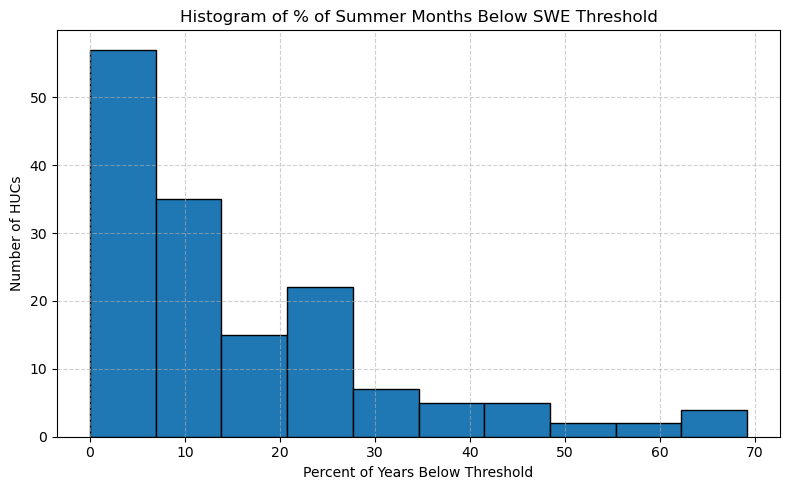

In [18]:
calc_and_plot(hucs_mar)

              percent_below_thresh
huc                               
170200090208              5.000000
170200090209              0.000000
170200090301              0.833333
170200090302             10.000000
170200090304              0.000000


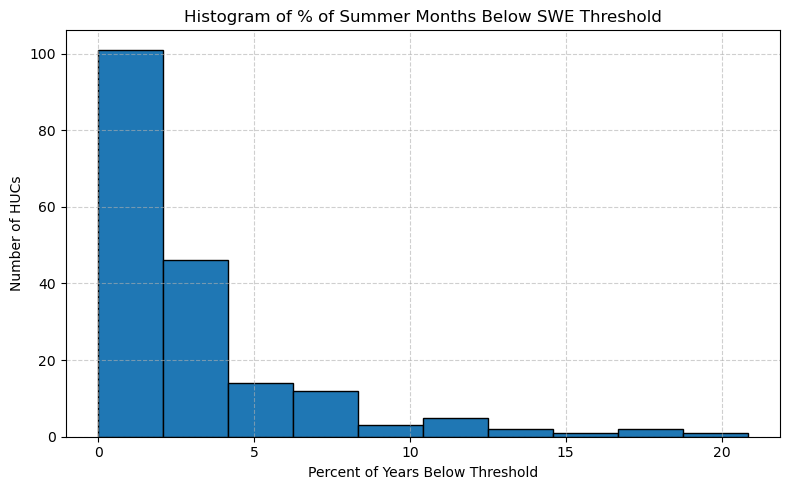

In [19]:
calc_and_plot(hucs_mont)


In [20]:
month_begin = 8
month_end = 9
threshold = 80
tot_idx = month_end-month_begin + 1

              percent_below_thresh
huc                               
170200090101                  8.75
170200090102                 12.50
170200090103                 10.00
170200090104                  2.50
170200090105                 17.50


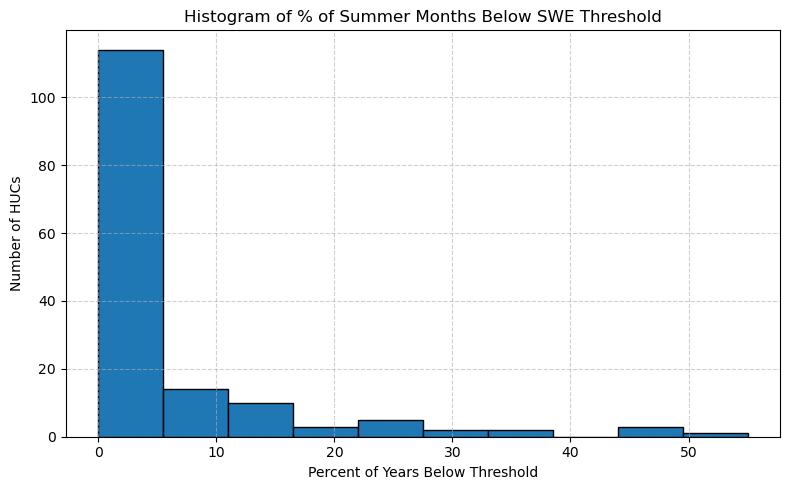

In [21]:
calc_and_plot(hucs_mar)

              percent_below_thresh
huc                               
170200090208                  3.75
170200090209                  0.00
170200090301                  1.25
170200090302                  6.25
170200090304                  0.00


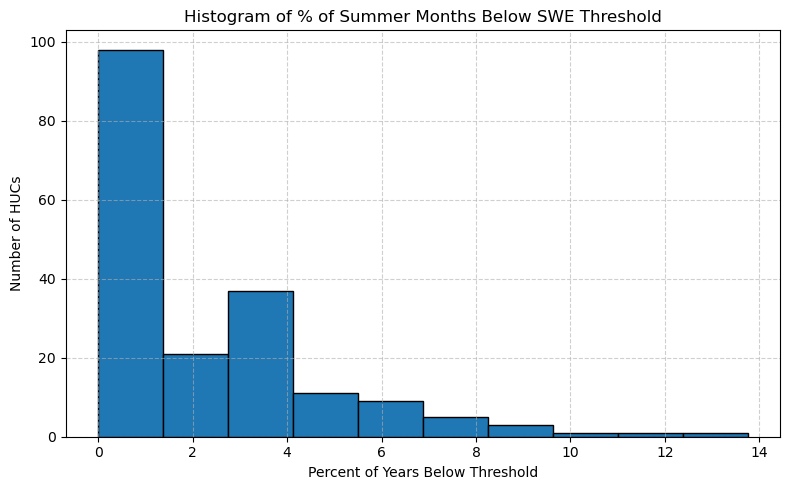

In [22]:
calc_and_plot(hucs_mont)